In [1]:
import torch
import pykeen
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pykeen.pipeline import pipeline
from sklearn.neighbors import NearestNeighbors
from pykeen.evaluation import RankBasedEvaluator
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

/home/space/miniconda3/envs/know/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/space/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from pykeen.datasets import Nations
dataset = Nations()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Задаем параметры для pipeline
pipeline_results = pipeline(
    model="ComplEx",
    dataset=dataset,
    training_kwargs=dict(num_epochs=100),
    device=device
)

No random seed is specified. Setting to 3954632604.
Training epochs on cuda:0: 100%|██████████| 100/100 [00:09<00:00, 11.01epoch/s, loss=5.92, prev_loss=6.25]
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=201.
Evaluating on cuda:0: 100%|██████████| 201/201 [00:00<00:00, 16.2ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

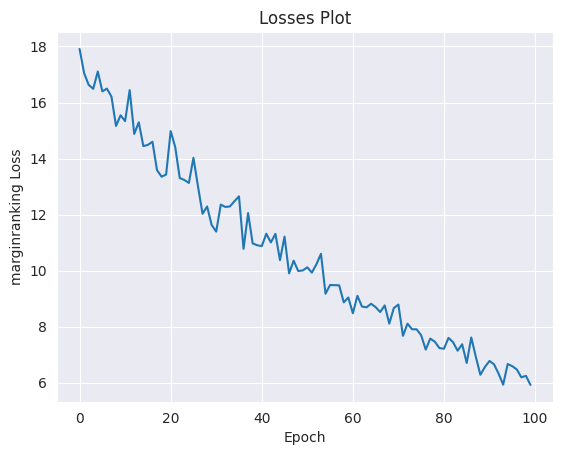

In [5]:
# Обученная модель хранится в pipeline_results
model = pipeline_results.model
pipeline_results.plot_losses()
#plot loss

In [6]:
# Создаем evaluator объект
evaluator = RankBasedEvaluator()

# Оценить работу модели
metrics = evaluator.evaluate(model, dataset.testing.mapped_triples,
                             additional_filter_triples=[dataset.training.mapped_triples,
                                                        dataset.validation.mapped_triples])

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=201.
Evaluating on cuda:0: 100%|██████████| 201/201 [00:00<00:00, 15.7ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds


Hits@1: 0.17661691542288557
Hits@3: 0.4626865671641791
Hits@5: 0.6965174129353234
Hits@10: 0.9676616915422885
Mean Reciprocal Rank: 0.39345753192901606


In [7]:
node_embeddings = pipeline_results.model.entity_representations

embedding_matrix = node_embeddings[0]._embeddings.weight.data

# Конвертируем матрицу весов в NumPy array
embedding_numpy = embedding_matrix.cpu().numpy()

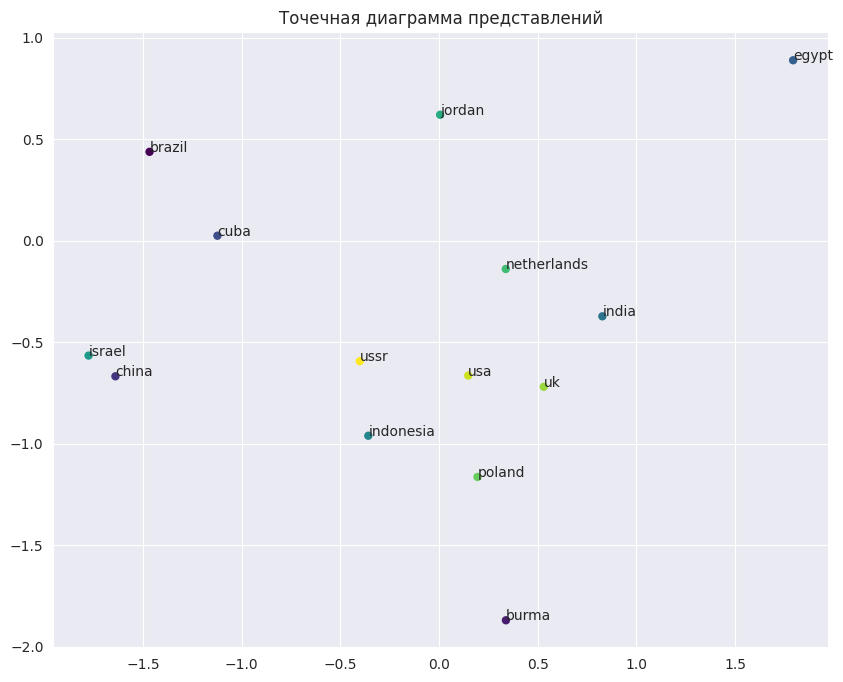

In [8]:
#Созраняем названия сущностей в отдельной переменной
id_to_lable = list(dataset.testing.entity_id_to_label.values())

def visualize_embeddings(embeddings, labels):
    # Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=np.arange(len(labels)), cmap='viridis', s=25)

    # Добавляем лейблы к точкаи на графике
    for i, label in enumerate(labels):
        plt.annotate(label, (embeddings[i, 0], embeddings[i, 1]), alpha=1)

    plt.title('Точечная диаграмма представлений')
    plt.show()

#Количество точек которые необходимо отобразить на графике
number = 25

visualize_embeddings(embedding_numpy[:number], id_to_lable[:number])

In [9]:
id_to_lable[-1]

'ussr'

[[ 0.       26.037693 26.490906 25.23274 ]
 [26.037693  0.       27.156403 27.084368]
 [26.490906 27.156403  0.       25.744057]
 [25.23274  27.084368 25.744057  0.      ]]


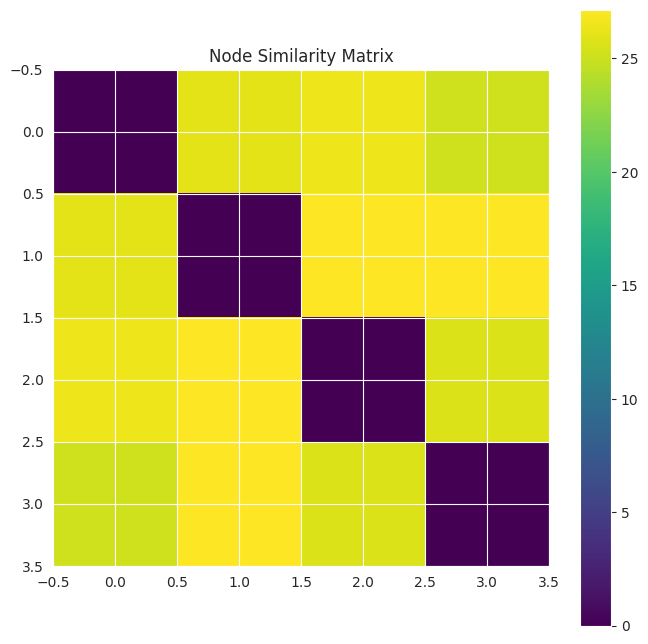

[[ 1.0000005   0.00728143 -0.00534033  0.04285496]
 [ 0.00728143  1.          0.00947268 -0.03082005]
 [-0.00534033  0.00947268  0.9999999   0.08816877]
 [ 0.04285496 -0.03082005  0.08816877  0.99999976]]


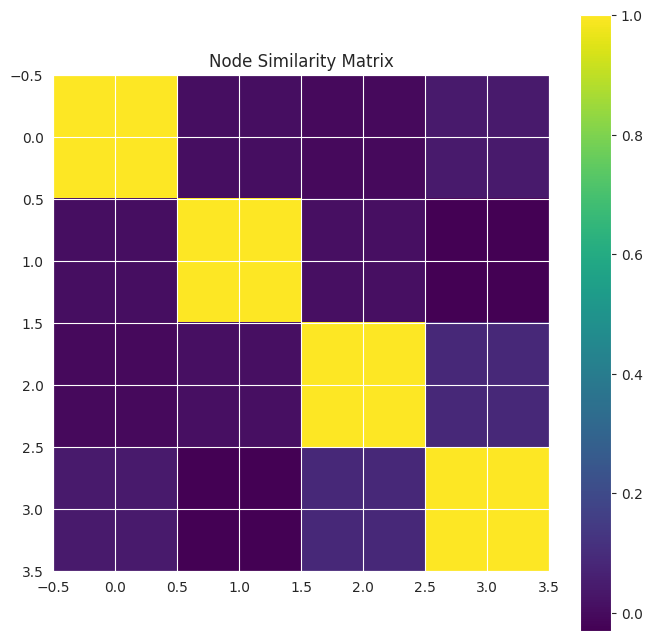

[[  0.         422.8999563  425.704654   404.54403152]
 [422.8999563    0.         424.64147801 434.96131023]
 [425.704654   424.64147801   0.         409.50194841]
 [404.54403152 434.96131023 409.50194841   0.        ]]


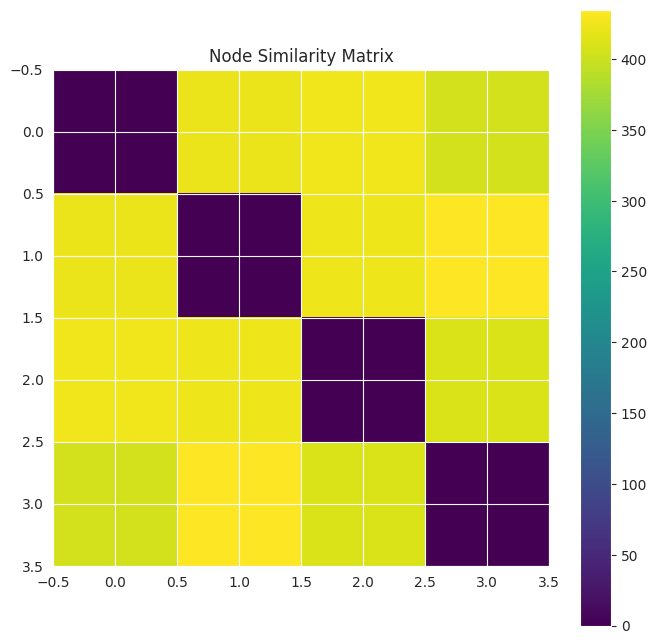

In [10]:
def diplay_matrix(similarity_matrix):
  # Визуализация матрицы близости
  plt.figure(figsize=(8, 8))
  plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
  plt.colorbar()
  plt.title('Node Similarity Matrix')
  plt.show()


# Рассчет близости между узлами
methods = [euclidean_distances,cosine_similarity,manhattan_distances]
#Узлы
nodes = [embedding_numpy[0],embedding_numpy[1],embedding_numpy[2],embedding_numpy[3]]
for method in methods:
  similarity_matrix = method(nodes)
  print(similarity_matrix)
  diplay_matrix(similarity_matrix)

In [11]:
# Выбираем случайный узел
random_node_index = 5
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[ 0.       24.843815 25.0549   25.103254]]
Индексы:[[ 5  7  0 11]]
Ближайшие соседи узла india: ['india', 'israel', 'brazil', 'uk'] 

Метрика:cosine
Дистанции:[[1.7881393e-07 9.0207666e-01 9.4980705e-01 9.5028651e-01]]
Индексы:[[ 5 13  3  7]]
Ближайшие соседи узла india: ['india', 'ussr', 'cuba', 'israel'] 

Метрика:manhattan
Дистанции:[[  0.         400.32888794 401.24746704 402.61096191]]
Индексы:[[ 5 11  7  0]]
Ближайшие соседи узла india: ['india', 'uk', 'israel', 'brazil'] 



In [12]:
# Выбираем случайный узел
random_node_index = 13
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[3.3717478e-07 2.5572290e+01 2.5745419e+01 2.6485147e+01]]
Индексы:[[13  5  0 12]]
Ближайшие соседи узла ussr: ['ussr', 'india', 'brazil', 'usa'] 

Метрика:cosine
Дистанции:[[0.         0.90207666 0.9191287  0.9347501 ]]
Индексы:[[13  5  0 12]]
Ближайшие соседи узла ussr: ['ussr', 'india', 'brazil', 'usa'] 

Метрика:manhattan
Дистанции:[[  0.         406.19787598 411.78100586 417.12716675]]
Индексы:[[13  5  0 12]]
Ближайшие соседи узла ussr: ['ussr', 'india', 'brazil', 'usa'] 



# Увеличим количество эпох

In [17]:
# Задаем параметры для pipeline
pipeline_results = pipeline(
    model="ComplEx",
    dataset=dataset,
    training_kwargs=dict(num_epochs=200),
    device=device
)

INFO:pykeen.pipeline.api:Using device: cuda
Training epochs on cuda:0: 100%|██████████| 200/200 [00:19<00:00, 10.06epoch/s, loss=2.12, prev_loss=2.24]
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=201.
Evaluating on cuda:0: 100%|██████████| 201/201 [00:00<00:00, 15.8ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

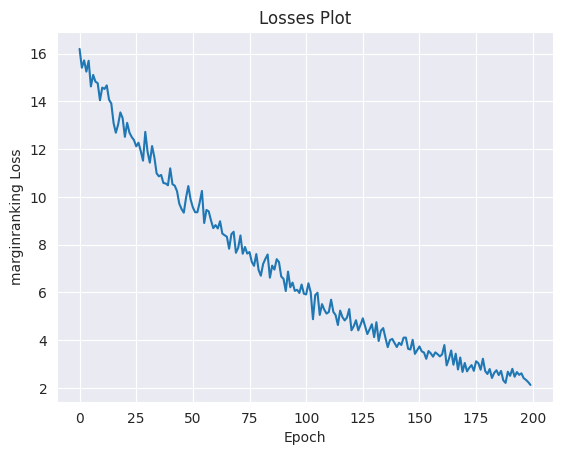

In [18]:
model = pipeline_results.model
pipeline_results.plot_losses()

In [19]:
# Создаем evaluator объект
evaluator = RankBasedEvaluator()

# Оценить работу модели
metrics = evaluator.evaluate(model, dataset.testing.mapped_triples,
                             additional_filter_triples=[dataset.training.mapped_triples,
                                                        dataset.validation.mapped_triples])

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=201.
Evaluating on cuda:0: 100%|██████████| 201/201 [00:00<00:00, 15.7ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds


Hits@1: 0.17661691542288557
Hits@3: 0.48258706467661694
Hits@5: 0.6766169154228856
Hits@10: 0.9353233830845771
Mean Reciprocal Rank: 0.39564794301986694


In [20]:
node_embeddings = pipeline_results.model.entity_representations

embedding_matrix = node_embeddings[0]._embeddings.weight.data

# Конвертируем матрицу весов в NumPy array
embedding_numpy = embedding_matrix.cpu().numpy()

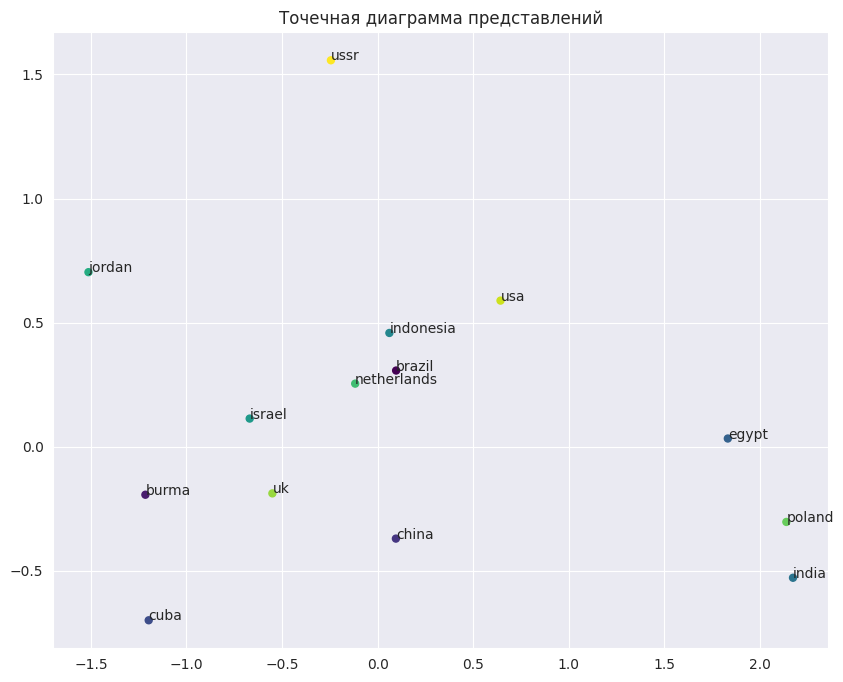

In [21]:
#Созраняем названия сущностей в отдельной переменной
id_to_lable = list(dataset.testing.entity_id_to_label.values())

def visualize_embeddings(embeddings, labels):
    # Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=np.arange(len(labels)), cmap='viridis', s=25)

    # Добавляем лейблы к точкаи на графике
    for i, label in enumerate(labels):
        plt.annotate(label, (embeddings[i, 0], embeddings[i, 1]), alpha=1)

    plt.title('Точечная диаграмма представлений')
    plt.show()

#Количество точек которые необходимо отобразить на графике
number = 25

visualize_embeddings(embedding_numpy[:number], id_to_lable[:number])

In [23]:
# Выбираем случайный узел
random_node_index = 5
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[ 0.       23.687859 24.347216 24.451313]]
Индексы:[[ 5  2  0 10]]
Ближайшие соседи узла india: ['india', 'china', 'brazil', 'poland'] 

Метрика:cosine
Дистанции:[[0.         0.8929622  0.8983325  0.92795444]]
Индексы:[[ 5  2  0 10]]
Ближайшие соседи узла india: ['india', 'china', 'brazil', 'poland'] 

Метрика:manhattan
Дистанции:[[  0.         377.65350342 389.79528809 399.1289978 ]]
Индексы:[[ 5  2 10  0]]
Ближайшие соседи узла india: ['india', 'china', 'poland', 'brazil'] 



In [26]:
# Выбираем случайный узел
random_node_index = 13
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[ 0.       25.418592 25.51914  25.601501]]
Индексы:[[13  7  4 10]]
Ближайшие соседи узла ussr: ['ussr', 'israel', 'egypt', 'poland'] 

Метрика:cosine
Дистанции:[[0.         0.952268   0.96538866 0.97659975]]
Индексы:[[13  7 11  6]]
Ближайшие соседи узла ussr: ['ussr', 'israel', 'uk', 'indonesia'] 

Метрика:manhattan
Дистанции:[[  0.         403.5892334  409.90228271 412.75830078]]
Индексы:[[13  7 10  3]]
Ближайшие соседи узла ussr: ['ussr', 'israel', 'poland', 'cuba'] 



# Обучим новую модель

In [27]:
pipeline_results = pipeline(
    model="TransE",
    dataset=dataset,
    training_kwargs=dict(num_epochs=100),
    device=device
)

INFO:pykeen.pipeline.api:Using device: cuda
Training epochs on cuda:0: 100%|██████████| 100/100 [00:09<00:00, 10.92epoch/s, loss=0.742, prev_loss=0.709]
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=201.
Evaluating on cuda:0: 100%|██████████| 201/201 [00:00<00:00, 16.7ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

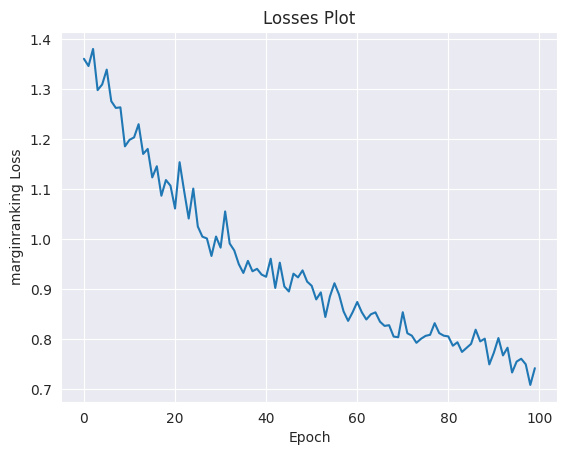

In [28]:
model = pipeline_results.model
pipeline_results.plot_losses()

In [29]:
# Создаем evaluator объект
evaluator = RankBasedEvaluator()

# Оценить работу модели
metrics = evaluator.evaluate(model, dataset.testing.mapped_triples,
                             additional_filter_triples=[dataset.training.mapped_triples,
                                                        dataset.validation.mapped_triples])

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=201.
Evaluating on cuda:0: 100%|██████████| 201/201 [00:00<00:00, 16.5ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds


Hits@1: 0.0
Hits@3: 0.5920398009950248
Hits@5: 0.7810945273631841
Hits@10: 0.9776119402985075
Mean Reciprocal Rank: 0.3381752371788025


In [30]:
node_embeddings = pipeline_results.model.entity_representations

embedding_matrix = node_embeddings[0]._embeddings.weight.data

# Конвертируем матрицу весов в NumPy array
embedding_numpy = embedding_matrix.cpu().numpy()

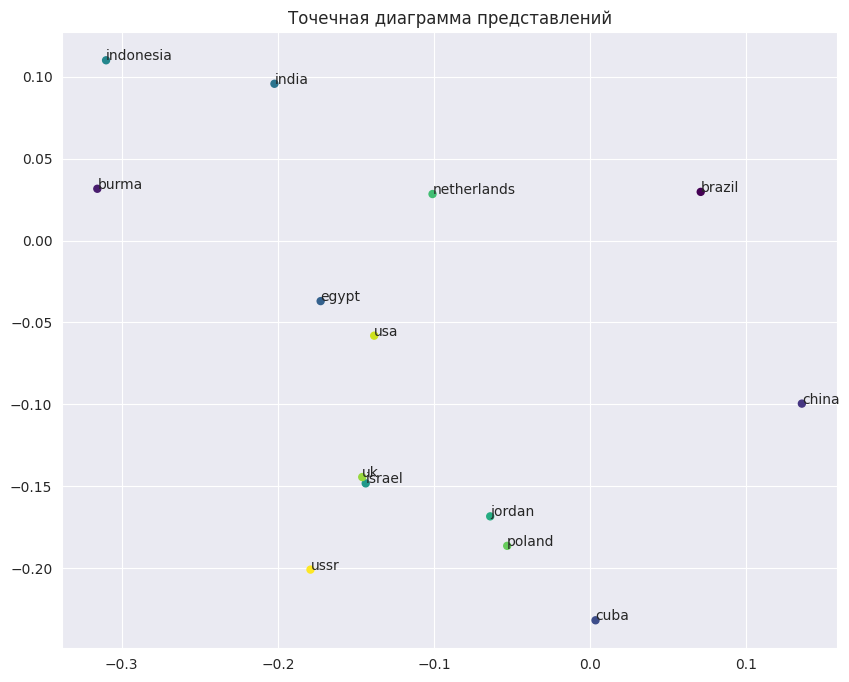

In [31]:
#Созраняем названия сущностей в отдельной переменной
id_to_lable = list(dataset.testing.entity_id_to_label.values())

def visualize_embeddings(embeddings, labels):
    # Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=np.arange(len(labels)), cmap='viridis', s=25)

    # Добавляем лейблы к точкаи на графике
    for i, label in enumerate(labels):
        plt.annotate(label, (embeddings[i, 0], embeddings[i, 1]), alpha=1)

    plt.title('Точечная диаграмма представлений')
    plt.show()

#Количество точек которые необходимо отобразить на графике
number = 25

visualize_embeddings(embedding_numpy[:number], id_to_lable[:number])

In [32]:
# Выбираем случайный узел
random_node_index = 5
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[0.         0.91917956 0.97989833 1.0903352 ]]
Индексы:[[ 5 12 11 10]]
Ближайшие соседи узла india: ['india', 'usa', 'uk', 'poland'] 

Метрика:cosine
Дистанции:[[0.         0.42244548 0.4801004  0.5944154 ]]
Индексы:[[ 5 12 11 10]]
Ближайшие соседи узла india: ['india', 'usa', 'uk', 'poland'] 

Метрика:manhattan
Дистанции:[[0.         5.25255966 5.25802422 5.75830078]]
Индексы:[[ 5 12 11  6]]
Ближайшие соседи узла india: ['india', 'usa', 'uk', 'indonesia'] 



In [33]:
# Выбираем случайный узел
random_node_index = 13
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)


Метрика:nan_euclidean
Дистанции:[[2.1073424e-08 9.0883487e-01 9.6212488e-01 9.7812563e-01]]
Индексы:[[13 10 12 11]]
Ближайшие соседи узла ussr: ['ussr', 'poland', 'usa', 'uk'] 

Метрика:cosine
Дистанции:[[5.9604645e-08 4.1299045e-01 4.6284211e-01 4.7836494e-01]]
Индексы:[[13 10 12 11]]
Ближайшие соседи узла ussr: ['ussr', 'poland', 'usa', 'uk'] 

Метрика:manhattan
Дистанции:[[0.         5.1204257  5.77905083 5.84685564]]
Индексы:[[13 10 11 12]]
Ближайшие соседи узла ussr: ['ussr', 'poland', 'uk', 'usa'] 

